In [2]:
%matplotlib inline
import os
import numpy as np
from PIL import Image;
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
def init_weight(name, shape, stddev=0.1):
    return tf.get_variable(name, 
                           shape=shape, 
                           dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))

def init_biases(name, shape, constant=0.1):
    return tf.get_variable(name, 
                           shape=shape, 
                           dtype=tf.float32, 
                           initializer=tf.constant_initializer(constant))

def inference(images, batch_size, n_classes):
    '''Build the model
    Args:
        images: image batch, 4D tensor, tf.float32, [batch_size, width, height, channels]
    Returns:
        output tensor with the computed logits, float, [batch_size, n_classes]
    '''
    #conv1, shape = [kernel size, kernel size, channels, kernel numbers]
    with tf.variable_scope('conv1') as scope:
        weights = init_weight("weights", shape = [3, 3, 3, 16])
        biases = init_biases("biases", shape=[16])
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)
    
    #pool1 and norm1
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1], padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75, name=scope.name)
    
    #conv2
    with tf.variable_scope('conv2') as scope:
        weights = init_weight("weights", shape=[3, 3, 16, 16])
        biases = init_biases("biases", shape=[16])
        conv = tf.nn.conv2d(norm1, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
    
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75, name=scope.name)
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME', name='pooling2')
    
    #local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = init_weight("weights", shape=[dim,128], stddev=0.005)
        biases = init_biases("biases", shape=[128])
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)    
    
    #local4
    with tf.variable_scope('local4') as scope:
        weights = init_weight("weights", shape=[128,128], stddev=0.005)
        biases = init_biases("biases", shape=[128])
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
     
    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = init_weight("softmax_linear", shape=[128, n_classes], stddev=0.005)
        biases = init_biases("biases", shape=[n_classes])
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    
    return softmax_linear

./data/test/6457.jpg
(208, 208, 3)
<class 'numpy.ndarray'>
Reading checkpoints...
INFO:tensorflow:Restoring parameters from D:/log/model.ckpt-400000
Loading success, global_step is 400000
This is a dog with possibility 1.000000


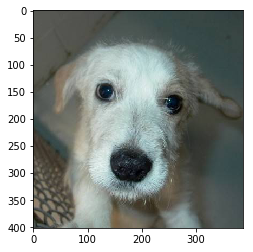

In [10]:
def get_one_img(img_dir):
    image = Image.open(img_dir)
    plt.ion()
    plt.imshow(image)
    image = image.resize([208, 208])
    image = np.array(image)
    return image

def get_img_list(file_dir):
    return os.listdir(file_dir)

'''Test one image against the saved models and parameters
'''

# you need to change the directories to yours.
test_dir = "./data/test/"
image_list = get_img_list(test_dir)
num_id = np.random.randint(0, len(image_list))
image_path = test_dir + str(num_id) + ".jpg"#image_list[2249 - 1]
print(image_path)
image_array = get_one_img(image_path)
print(image_array.shape)
print(type(image_array))

with tf.Graph().as_default():
    BATCH_SIZE = 1
    N_CLASSES = 2
    image = tf.cast(image_array, tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.reshape(image, [1, 208, 208, 3])
    logit = inference(image, BATCH_SIZE, N_CLASSES)

    logit = tf.nn.softmax(logit)

    logs_train_dir = 'd:/log/' 

    saver = tf.train.Saver()

    with tf.Session() as sess:
        print("Reading checkpoints...")
        ckpt = tf.train.get_checkpoint_state(logs_train_dir) # 获取保存的参数
        if ckpt and ckpt.model_checkpoint_path:
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
            saver.restore(sess, ckpt.model_checkpoint_path) # 载入数据
            print('Loading success, global_step is %s' % global_step)
        else:
            print('No checkpoint file found')
        num_id = np.random.randint(0, len(image_list))
        image_array = get_one_img(test_dir + str(num_id) + ".jpg")
        
        prediction = sess.run(logit)
        max_index = np.argmax(prediction)
        if max_index==0:
            print('This is a cat with possibility %.6f' %prediction[:, 0])
        else:
            print('This is a dog with possibility %.6f' %prediction[:, 1])

### 优化模型可以使用以下几点  
1. 模型的数据在生成的时候要将数据打乱，不然会让模型陷入过拟合状态  
2. loss function 需要通过改变不同的function来尝试模型的调优  
3. 在训练模型的时候，可以增加模型的训练次数  
4. 使用不同的优化函数
5. 使用不同的batch_size